<a href="https://colab.research.google.com/github/NewAnik/DataScience/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
#mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [ ]:
#mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [ ]:
# 1
num_workers = 0
# 2
batch_size = 64
# 3
transform = transforms.ToTensor()
# 4
train_data = datasets.MNIST(root='data', train=True,
 download=True, transform=transform)
# 5
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)

In [ ]:
len(train_loader)


938

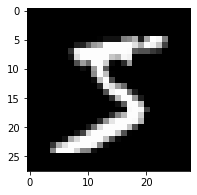

In [ ]:
#1 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
#2
img = np.squeeze(images[0])
fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()
 
 # 1
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
 
 # 2
    self.fc4 = nn.Linear(hidden_dim, output_size)
 
 # dropout layer 
    self.dropout = nn.Dropout(0.3)
 
 
  def forward(self, x):
 #3 
    x = x.view(-1, 28*28)
 #4 
    x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
 # 5
    out = self.fc4(x)
    return out

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator, self).__init__()
 
 # 1
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
 
 # 2
    self.fc4 = nn.Linear(hidden_dim*4, output_size)
 
 # 3
    self.dropout = nn.Dropout(0.3)
  def forward(self, x):
 # 4
    x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
 # 5
    out = F.tanh(self.fc4(x))
    return out

In [ ]:
# Discriminator hyperparameters
# 1
input_size = 784
# 2
d_output_size = 1
# 3
d_hidden_size = 32
# Generator hyperparams
# 4
z_size = 100
# 5
g_output_size = 784
# 6
g_hidden_size = 32

In [ ]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)
# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
 batch_size = D_out.size(0)
 # label smoothing
 if smooth:
 # smooth, real labels = 0.9
  labels = torch.ones(batch_size)*0.9
 else:
  labels = torch.ones(batch_size) # real labels = 1
 
 # numerically stable loss
 criterion = nn.BCEWithLogitsLoss()
 # calculate loss
 loss = criterion(D_out.squeeze(), labels)
 return loss
def fake_loss(D_out):
 batch_size = D_out.size(0)
 labels = torch.zeros(batch_size) # fake labels = 0
 criterion = nn.BCEWithLogitsLoss()
 # calculate loss
 loss = criterion(D_out.squeeze(), labels)
 return loss

In [ ]:
import torch.optim as optim
lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3786 | g_loss: 0.7076
Epoch [    1/  100] | d_loss: 1.0481 | g_loss: 4.0675
Epoch [    1/  100] | d_loss: 1.0536 | g_loss: 1.2011
Epoch [    2/  100] | d_loss: 1.6421 | g_loss: 0.6373
Epoch [    2/  100] | d_loss: 0.8308 | g_loss: 1.7854
Epoch [    2/  100] | d_loss: 1.3120 | g_loss: 0.8232
Epoch [    3/  100] | d_loss: 1.2293 | g_loss: 0.7817
Epoch [    3/  100] | d_loss: 1.1336 | g_loss: 1.1842
Epoch [    3/  100] | d_loss: 1.4989 | g_loss: 0.6847
Epoch [    4/  100] | d_loss: 1.0473 | g_loss: 2.1237
Epoch [    4/  100] | d_loss: 1.2155 | g_loss: 1.1755
Epoch [    4/  100] | d_loss: 1.4246 | g_loss: 1.0132
Epoch [    5/  100] | d_loss: 1.2628 | g_loss: 0.7201
Epoch [    5/  100] | d_loss: 1.0843 | g_loss: 1.3223
Epoch [    5/  100] | d_loss: 1.0803 | g_loss: 1.1718
Epoch [    6/  100] | d_loss: 1.2275 | g_loss: 1.2290
Epoch [    6/  100] | d_loss: 0.9920 | g_loss: 1.2678
Epoch [    6/  100] | d_loss: 1.3000 | g_loss: 0.9269
Epoch [    7/  100] | d_loss